
# Face Recognition : 
A comparison of Principal Components Analysis (PCA) and Convolutional Neural Networks (CNN)

## Convolutional Neural Network Implementation :
Here, I will be using the pytorch library, and use the common architecture called LeNet introduced by the French computer scientist Yann Lecun in 1989.

### Neural network definition : 
We define our architecture according to the LeNet-5 model :

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 14)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### Access to the dataset :
This step is simply done to make data retrival through our files easier.

In [16]:
import os
import cv2 as cv
from torch.utils.data import Dataset

class FacesDataset(Dataset):

    def __init__(self, data_path, transform = None, target_transform = None):
        self.data_path = data_path
        self.image_labels = dict()  # {"path": "label"}
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = []

        for directory in os.listdir(data_path):
            for file in os.listdir(os.path.join(data_path, directory)):
                self.image_paths.append(os.path.join(data_path, directory, file))
                self.image_labels[os.path.join(data_path, directory, file)] = int(directory)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv.imread(img_path)
        label = self.image_labels[img_path]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Preparation of the training set and of the testing set :



In [17]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import pathlib

# Transformation used to normalize the data
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 8

# Definition of the loaders that will give access to the data
train_data_path = os.path.join( "data_png_64x64","train")
test_data_path = os.path.join("data_png_64x64","test")

train_dataset = FacesDataset(train_data_path, transform=transforms)
test_dataset = FacesDataset(test_data_path, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Function used to determine how the loss of the neural network is calculated after each pass 
criterion = nn.CrossEntropyLoss()
# The optimizer is the algorithm which determines how to tweak the parameters of the model in order to get more accurate predictions
optimizer = optim.Adam(net.parameters())
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Testing Dataset Size: {len(test_dataset)}")

Training Dataset Size: 102
Testing Dataset Size: 50


### Training our network :
The goal of this section is to determine how much the model should be trained, and then determine how long it takes once we'll have found the good number of epochs for training.


Epoch [1] loss: 2.640
Epoch [2] loss: 2.509
Epoch [3] loss: 2.009
Epoch [4] loss: 0.980
Epoch [5] loss: 0.459
Epoch [6] loss: 0.467
Epoch [7] loss: 0.238
Epoch [8] loss: 0.070
Epoch [9] loss: 0.019
Epoch [10] loss: 0.005
Training took : 1.274 seconds


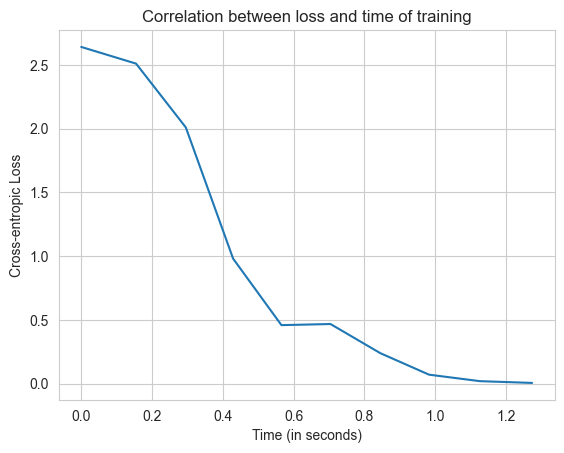

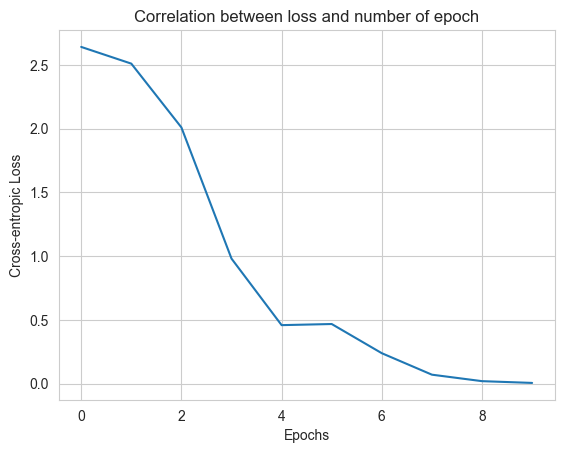

In [18]:
import time
import seaborn as sns
import matplotlib.pyplot as plt

times = []
losses = []
epochs = []
epoch_number = 10
for epoch in range(epoch_number):  # loop over the dataset multiple times (epochs)
    
    running_loss = 0.0
    batches_counter = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
    
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        batches_counter += 1
        
    # save current state after each epoch
    print(f'Epoch [{epoch + 1}] loss: {running_loss/batches_counter :.3f}')
    times.append(time.time())
    losses.append(running_loss/batches_counter)
    epochs.append(epoch)
    running_loss = 0.0

# Displaying the data
start = times[0]
for i in range(len(times)):
    times[i] = times[i] - start
    
print(f"Training took : {times[-1]:.3f} seconds")

sns.lineplot(x=times, y=losses)
plt.title('Correlation between loss and time of training')
plt.xlabel('Time (in seconds)')
plt.ylabel('Cross-entropic Loss')
plt.show()

sns.lineplot(x=epochs, y=losses)
plt.title('Correlation between loss and number of epoch')
plt.xlabel('Epochs')
plt.ylabel('Cross-entropic Loss')
plt.show()


            


### Testing our network :

Errors of prediction :
13 != 8
6 != 13
4 != 9
3 != 4
Prediction time : 0.04355s - Average 0.00087s/image
Accuracy : 0.92
Tested 50 images


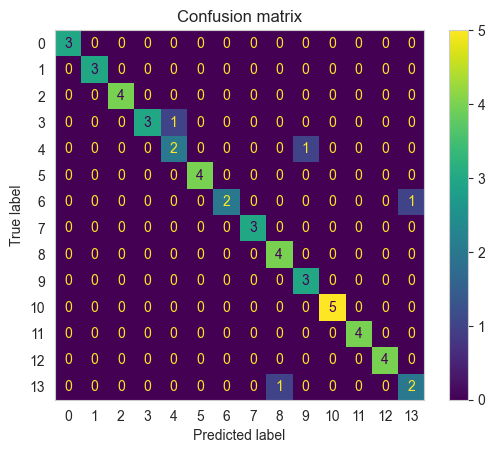

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

test_iterator = iter(test_loader)

true_labels = []
predicted_labels = []
start = time.time()
print(f"\033[95mErrors of prediction :\033[0m")
for images, labels in test_iterator:
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    for j in range(len(predicted)):
        if labels[j] != predicted[j]:
            print(f'\033[91m{labels[j]} != {predicted[j]}\033[0m' )
        true_labels.append(labels[j].item())
        predicted_labels.append(predicted[j].item())

duration = time.time() - start
print(f"Prediction time : {duration:.5f}s - Average {duration/len(test_dataset):.5f}s/image")
print(f"Accuracy : {accuracy_score(true_labels, predicted_labels)}")
print(f"Tested {len(test_dataset)} images")


# Confusion Matrix 
classes = list(set(true_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=classes)
display_confusion_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
display_confusion_matrix.plot()
plt.title("Confusion matrix")
plt.grid(False)
plt.show()


We can notice after this step and a few tests on the variable epoch-number, that the value of epoch_number = 10 seems to rather suitable. During my tests, it offers a training duration of around 1.2 seconds, with final accuracies being around 0.90 to 0.96 in the luckiest case. Therefor, 10 is the epoch_number value that we are going to keep for our "time" of training in the following steps of our comparison.

## Principal component analysis (PCA) implementation
PCA is not a tool that makes prediction, PCA is used to reduce the dimension of data by studying wich components carry the most information in the vectors that describe the different features of a record.
In our case, the features are the values of the pixel that composes the images.
In order to make predicition, we will need to add a classifier. 

### Loading normalized datasets
Retriving our training and testing datasets.

In [20]:
from pathlib import Path
import numpy as np

# loads images from the directory containing each images classified in a sub-directory that has the name of the corresponding class
def load_image_files(container_path):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [folder.name for folder in folders]
    images = []
    flat_data = []
    target = []

    for i, directory in enumerate(folders):
        for file in directory.iterdir():
            img = cv.imread(file)
            flat_data.append(np.array(img).flatten())  # Flattens the images into mono-dimensional vectors 
            images.append(img)
            target.append(i)

    flat_data = np.array(flat_data)
    target = np.array(target)
    return flat_data, target, images, categories

dataset_path_train = "C:\\Users\\eveil\\DataspellProjects\\face-recognition_acp-vs-cnn\\data_png_64x64\\train"
dataset_path_test = "C:\\Users\\eveil\\DataspellProjects\\face-recognition_acp-vs-cnn\\data_png_64x64\\test"

X_train, Y_train, images_train, class_names = load_image_files(dataset_path_train)
X_test, Y_test, images_test, class_test = load_image_files(dataset_path_test)


print(f"\033[95mTraining set\033[0m number of pictures : {len(X_train)}")
print(f"\033[95mTesting set\033[0m number of pictures : {len(X_test)}")
print(f"Classes : {class_names}")

Training set number of pictures : 102
Testing set number of pictures : 50
Classes : ['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']


### Defining our PCA model :


In [21]:
from sklearn import decomposition

pca = decomposition.PCA(n_components= 70) # nombre de composantes conservées
start_training_pca = time.time()
pca.fit_transform(X_train)
duration_training_pca = time.time() - start_training_pca
print(f"Time spent training PCA : {duration_training_pca:.3f} seconds")
mean_image_flat = pca.mean_
mean_image = np.reshape(mean_image_flat, (64, 64, 3))
print(f"{sum(pca.explained_variance_ratio_)*100:0f}% of information kept with {pca.n_components_} components")

Time spent training PCA : 1.259 seconds
96.363030% of information kept with 70 components


### Defining and training our k-NN model :

We need to find the class that fits the closest to our sample once transformed using pca.

Let's do that by using the K-nearest-neighbours classifier.

The value of 1 for k is found later in the process.


In [22]:
from sklearn.neighbors import KNeighborsClassifier


def get_knn_classifier(X_train, Y_train, n_neighbours = 1):
    knn = KNeighborsClassifier(n_neighbors=n_neighbours)
    knn.fit(X_train, Y_train)

    return knn

X_train_reduced = pca.transform(X_train)
start_training = time.time()
knn = get_knn_classifier(X_train_reduced, Y_train)
duration_training_knn = time.time() - start_training
print(f"Time spent training the kNN model: {duration_training_knn:.3f} seconds")

Time spent training the kNN model: 0.002 seconds


### Testing our ACP/k-NN classifier :

Errors of prediction :
0 != 13
8 != 13
8 != 13
accuracy = 0.94
Prediction time : 0.24055s - Average 0.00481s/image
Tested 50 images


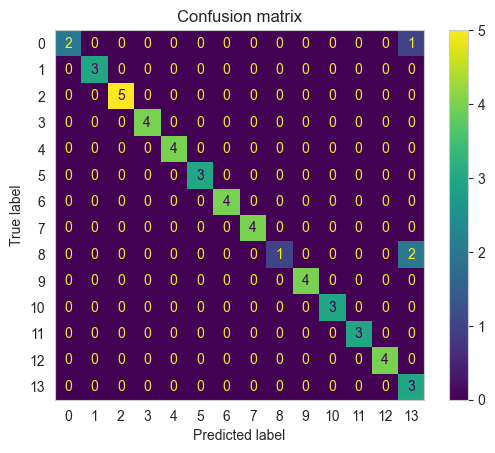

In [23]:
X_test_reduced = pca.transform(X_test)
start = time.time()
Y_pred = knn.predict(X_test_reduced)
duration_prediction_pca = time.time() - start

print(f"\033[95mErrors of prediction :\033[0m")
for true, predicted in zip(Y_test, Y_pred):
    if true != predicted:
        print(f'\033[91m{true} != {predicted}\033[0m' )
    
print(f"accuracy = {accuracy_score(Y_test, Y_pred)}")
print(f"Prediction time : {duration_prediction_pca:.5f}s - Average {duration_prediction_pca/len(X_test):.5f}s/image")
print(f"Tested {len(Y_pred)} images")


# Confusion Matrix 
classes = list(set(Y_test))
classes.sort()
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=classes)
display_confusion_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
display_confusion_matrix.plot()
plt.title("Confusion matrix")
plt.grid(False)
plt.show()


 ### Enhancing our k-value :
 
The prediction score is quite good, we could try to optimize our model even more. Let's find a better (or the best) value of k for the knn-classifier.
 

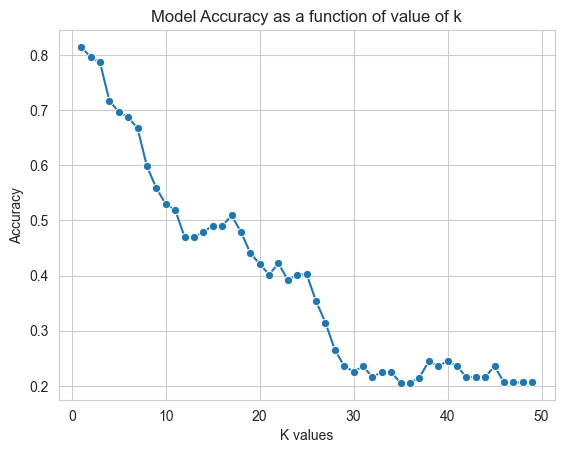

In [24]:
from sklearn.model_selection import cross_val_score

def find_better_k(X, Y):
    k_values = [i for i in range(1, 50)]
    scores = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        score = cross_val_score(knn, X, Y, cv=5)
        scores.append(np.mean(score))

    # display the result
    sns.lineplot(x = k_values, y = scores, marker = 'o')
    plt.title("Model Accuracy as a function of value of k")
    plt.xlabel("K values")
    plt.ylabel("Accuracy")
    plt.show()

find_better_k(X_train_reduced, Y_train)

By looking at the plot we see that 1 is a good choice for the value of k since the maximum accuracy is reached at k = 1